# Introduction

This project involves using deep learning techniques such as RNNs and LSTMs for sequential data analysis in order to determine whether or not a tweet is related to a real disaster. This is a natural language processing (NLP) intense workload and primarily uses Keras for model building, and sklearn and nltk in addition to Keras for text pre-processing.

Data consists of 160-character tweets, along with location and keyword if available. Training set contains 7613 tweets, and the test set contains 3263 tweets.

In [99]:
#First load up any packages that will be needed
import os
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn as sk
import statsmodels.api as sm
import seaborn as sns
from pathlib import Path

from nltk import sent_tokenize, word_tokenize, regexp_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import tf2onnx
import onnx
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Flatten, GlobalMaxPool1D, BatchNormalization, Embedding

In [2]:
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')

Load data into dataframes

In [3]:
root = Path('twitter')
file = 'train.csv'
df_train = pd.read_csv(root / file)
file = 'test.csv'
df_test = pd.read_csv(root / file)

df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


It appears from this output, there are numerous `NaN` values in the `keyword` and `location` features.

In [4]:
df_train.shape

(7613, 5)

In [5]:
df_test.shape

(3263, 4)

Total missing values 2594
Location missing values 2533
Keyword missing values 61


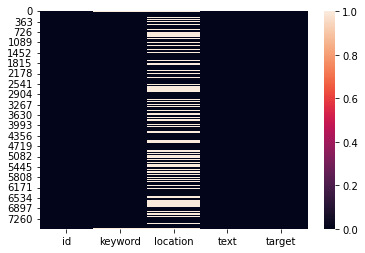

In [6]:
sns.heatmap(df_train.isna());
print("Total missing values", df_train.isna().values.sum())
print("Location missing values", df_train['location'].isna().sum())
print("Keyword missing values", df_train['keyword'].isna().sum())

Look at distribution of target data.

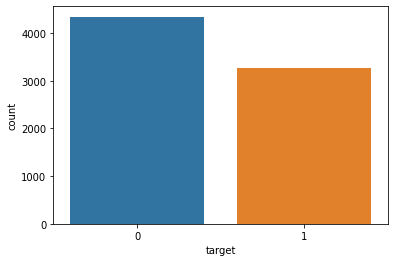

In [7]:
sns.countplot(x=df_train['target']);

It appears 2533 of the 2594 total missing values are in the `location` feature. The remaining 61 missing values are in the `keyword` feature. A large number of these just happen to appear in tweets low `id` values and as such many of the values appear as `NaN` when called by the `head()` function.

Looking at the data, there also appears to be issues with `keyword` data as it is URI encoded and has replaced spaces in between keywords with a `%20`. This should be removed.

In [8]:
df_train['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [9]:
df_train['keyword']  = df_train['keyword'].str.replace('%20',' ') #Replace URI encoded spaces with actual spaces

In [10]:
df_train['keyword'].value_counts()

fatalities             45
deluge                 42
armageddon             42
sinking                41
damage                 41
                       ..
forest fire            19
epicentre              12
threat                 11
inundation             10
radiation emergency     9
Name: keyword, Length: 221, dtype: int64

Look at text lengths

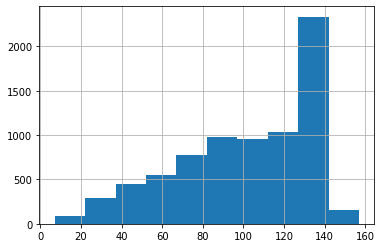

In [11]:
df_analyze = df_train.copy()
df_analyze['length'] = df_analyze['text'].str.len()
df_analyze['length'].hist();

In [12]:
stop_words = set(stopwords.words("english"))
df_analyze['sentences'] = df_analyze['text'].apply(lambda x: sent_tokenize(x))
df_analyze['sent_count'] = df_analyze['sentences'].apply(lambda x: len(x))
df_analyze['tokens_long'] = df_analyze['text'].apply(lambda x: word_tokenize(x))
df_analyze['tokens_long'] = df_analyze['tokens_long'].apply(lambda x: [word.lower() for word in x if word.isalpha()])
df_analyze['tokens'] = df_analyze['tokens_long'].apply(lambda x: [word for word in x if not word in stop_words])
df_analyze['word_count'] = df_analyze['tokens_long'].apply(lambda x: len(x))
df_analyze['words_per_sent'] = df_analyze['word_count'] / df_analyze['sent_count']
df_analyze.head()

,id,keyword,location,text,target,length,sentences,sent_count,tokens_long,tokens,word_count,words_per_sent
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,[Our Deeds are the Reason of this #earthquake ...,1,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...",13,13.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,"[Forest fire near La Ronge Sask., Canada]",2,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]",7,3.5
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,[All residents asked to 'shelter in place' are...,2,"[all, residents, asked, to, in, place, are, be...","[residents, asked, place, notified, officers, ...",21,10.5
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,"[13,000 people receive #wildfires evacuation o...",1,"[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order...",7,7.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,[Just got sent this photo from Ruby #Alaska as...,1,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...",16,16.0


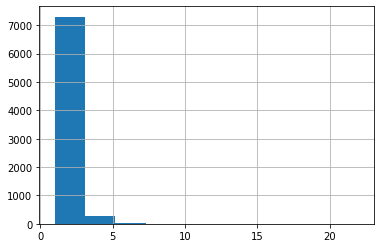

In [13]:
df_analyze['sent_count'].hist();

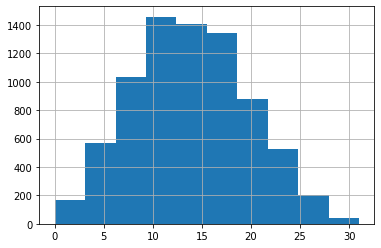

In [14]:
df_analyze['word_count'].hist();

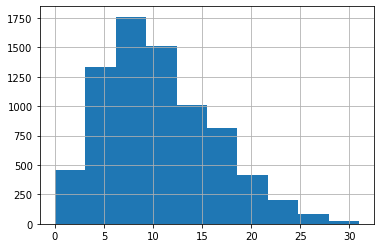

In [15]:
df_analyze['words_per_sent'].hist();

# Data Cleaning

Before data cleaning, there are symbols, punctuation, hashtags, a mix of uppercase and lowercase letters. It will be much simpler to remove these through data cleaning.

In [16]:
df_train['text'].head()

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

The result can be seen after cleaning:

In [23]:
def clean_text(text):
    stop_words = set(stopwords.words("english"))
    
    text = text.lower()
    text = re.sub("\'", "", text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('http?://\S+|www\.\S+', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("[^A-Za-z0-9 ]"," ",text)
    text = re.sub('\n', '', text)
    text = re.sub(r'\s+', ' ', text)
    words = regexp_tokenize(text, r'\w+')
    filtered_words = [word for word in words if word not in stop_words]
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    filtered_words = [stemmer.stem(word) for word in filtered_words]
    filtered_words = [lemmatizer.lemmatize(word, pos=wordnet.VERB) for word in filtered_words]
    return " ".join(words)

df_train['text_clean'] = df_train['text'].apply(clean_text)
df_test['text_clean'] = df_test['text'].apply(clean_text)
df_train['text_clean'].tail()

7608    two giant cranes holding a bridge collapse int...
7609    aria ahrary thetawniest the out of control wil...
7610                        m1 94 5km s of volcano hawaii
7611    police investigating after an e bike collided ...
7612    the latest more homes razed by northern califo...
Name: text_clean, dtype: object

Use keras Tokenizer to tokenize cleaned text into a sequence of words, chunks of words and special tokens to have a clear divide of even tokens for processing.

Then perform word embedding to convert the tokens to numbers that can be used to train the weights and biases of the model.

In [28]:
texts = df_train['text_clean'].values
targets = df_train['target'].values

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
vocab_len = len(tokenizer.word_index) + 1
print(f'Vocab length: {vocab_len}')

Vocab length: 17081


In [63]:
def embed(corpus): 
    return tokenizer.texts_to_sequences(corpus)

longest_train = max(texts, key=lambda sent: len(word_tokenize(sent)))
length_long_sentence = len(word_tokenize(longest_train))

texts_padded = pad_sequences(embed(texts), length_long_sentence, padding='post')
pred_text = pad_sequences(embed(df_test['text_clean'].values), length_long_sentence, padding='post')

texts_padded

array([[ 114, 4539,   21, ...,    0,    0,    0],
       [ 185,   42,  222, ...,    0,    0,    0],
       [  38, 1741, 1613, ...,    0,    0,    0],
       ...,
       [2804, 2389, 1602, ...,    0,    0,    0],
       [  75, 1140,   39, ...,    0,    0,    0],
       [   1,  209,   51, ...,    0,    0,    0]])

Load GloVe, which uses aggregated global word-word coccurance statistics from the entire collection of tweets.

In [44]:
embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype=np.float32)
        embeddings_dictionary [word] = vector_dimensions

embedding_matrix = np.zeros((vocab_len, embedding_dim))

for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.27085999,  0.044006  , -0.02026   , ..., -0.4923    ,
         0.63687003,  0.23642001],
       ...,
       [ 0.19814   , -0.33517   , -0.13950001, ..., -0.070356  ,
        -0.18391   ,  0.62439001],
       [-0.25161999,  0.73246998,  0.30792999, ..., -0.89315999,
         1.29760003, -0.04898   ],
       [-0.17609   , -0.049419  ,  0.28481001, ..., -1.47909999,
         0.53746998, -0.64883   ]])

Split data into training and validation sets with a 15% validation set stratifed on target.

In [31]:
X_train, X_val, y_train, y_val = train_test_split(texts_padded, targets, test_size=0.15, random_state=1, stratify=df_train['target'])

In [32]:
X_train

array([[ 1190,   245,  1505, ...,     0,     0,     0],
       [16900,     8, 16901, ...,     0,     0,     0],
       [14609,   369,    57, ...,     0,     0,     0],
       ...,
       [ 3436,    44,    29, ...,     0,     0,     0],
       [  194,   695,    72, ...,     0,     0,     0],
       [  528,  1964,  1693, ...,     0,     0,     0]])

In [33]:
y_train

array([0, 1, 1, ..., 0, 1, 1], dtype=int64)

In [34]:
X_val

array([[   13,   557,   294, ...,     0,     0,     0],
       [ 2527,  2685,    73, ...,     0,     0,     0],
       [   95,  1828,  1361, ...,     0,     0,     0],
       ...,
       [  172,  1411,  4750, ...,     0,     0,     0],
       [ 1410,     5,   903, ...,     0,     0,     0],
       [15236,    29,   466, ...,     0,     0,     0]])

In [35]:
y_val

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

In [100]:
def get_model():
    optimizer = RMSprop(momentum=0.1)
    model = Sequential(name='BidirectionLSTM')
    model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights=[embedding_matrix], input_length=length_long_sentence))
    model.add(Bidirectional(LSTM(length_long_sentence, return_sequences=True, recurrent_dropout=0.3)))
    model.add(Bidirectional(LSTM(length_long_sentence, return_sequences=True, recurrent_dropout=0.3)))
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = get_model()
model.summary()

Model: "BidirectionLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 33, 100)           1708100   
                                                                 
 bidirectional_16 (Bidirect  (None, 33, 66)            35376     
 ional)                                                          
                                                                 
 bidirectional_17 (Bidirect  (None, 33, 66)            26400     
 ional)                                                          
                                                                 
 global_max_pooling1d_11 (G  (None, 66)                0         
 lobalMaxPooling1D)                                              
                                                                 
 batch_normalization_11 (Ba  (None, 66)                264       
 tchNormalization)                                 

Tried changing number of layers, adding LSTM units, removing LSTM units. Initial increase in number of units actually decreased performance.

Also tried using different number of epochs for training from 5-25 to find an optimal stopping point.

Finally, tried tuning with different optimizers and the optimizer hyperparameters for increasing performance.

In [101]:
history = model.fit(X_train, y_train, epochs = 7, batch_size = 64, validation_data = (X_val, y_val))

Epoch 1/7
102/102 [==============================] - 10s 43ms/step - loss: 0.6835 - accuracy: 0.6373 - val_loss: 0.6531 - val_accuracy: 0.7898
Epoch 2/7
102/102 [==============================] - 4s 41ms/step - loss: 0.5452 - accuracy: 0.7449 - val_loss: 0.5906 - val_accuracy: 0.8109
Epoch 3/7
102/102 [==============================] - 4s 40ms/step - loss: 0.4889 - accuracy: 0.7866 - val_loss: 0.4984 - val_accuracy: 0.8319
Epoch 4/7
102/102 [==============================] - 4s 38ms/step - loss: 0.4330 - accuracy: 0.8258 - val_loss: 0.4433 - val_accuracy: 0.8310
Epoch 5/7
102/102 [==============================] - 4s 37ms/step - loss: 0.3842 - accuracy: 0.8516 - val_loss: 0.4202 - val_accuracy: 0.8266
Epoch 6/7
102/102 [==============================] - 4s 37ms/step - loss: 0.3239 - accuracy: 0.8804 - val_loss: 0.4028 - val_accuracy: 0.8380
Epoch 7/7
102/102 [==============================] - 4s 37ms/step - loss: 0.2708 - accuracy: 0.9034 - val_loss: 0.4490 - val_accuracy: 0.8109


Text(0, 0.5, 'Accuracy')

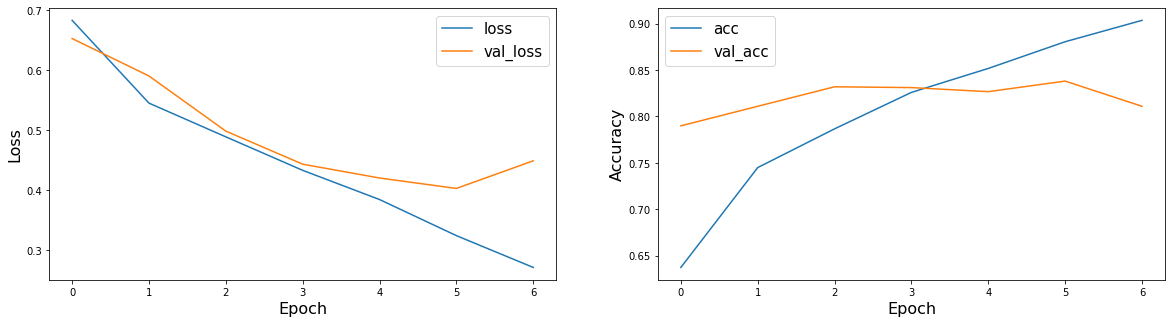

In [104]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].legend(['loss', 'val_loss'],fontsize=15)
ax[0].set_xlabel('Epoch',fontsize=16)
ax[0].set_ylabel('Loss',fontsize=16)
ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].legend(['acc', 'val_acc'],fontsize=15)
ax[1].set_xlabel('Epoch',fontsize=16)
ax[1].set_ylabel('Accuracy',fontsize=16)

In [96]:
predicted_labels = model.predict(pred_text)
df_test['target'] = np.round(predicted_labels.flatten()).astype('int')
df_test.head()

102/102 [==============================] - 1s 8ms/step


,id,keyword,location,text,text_clean,target
0,0,NaN,NaN,Just happened a terrible car crash,just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard about earthquake is different cities sta...,1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are ...,1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 in china and taiwan,1


In [97]:
df_test.drop(['keyword', 'location', 'text', 'text_clean'], axis=1).to_csv('predictions.csv', index=False)

In [98]:
# Save model
model.save('Complete.keras')

onnx_model, _ = tf2onnx.convert.from_keras(model, opset=13)
onnx.save(onnx_model, "model.onnx")

References: https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained#7.-LSTM